# Setup

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import pingouin as pg
from pingouin import pairwise_gameshowell

# File import

In [2]:
cleavage = pd.read_excel(
    'Cleavage positions.xlsx', 
    sheet_name = 'wtCas9_sgRNA2', 
    skiprows = 1, 
   # index_col = [0])
).replace('None', np.nan)
no_log = cleavage.drop('cleavage_rate_log', axis = 'columns').drop('cleavage_rate_log_unc', axis = 'columns').drop('descriptor', axis = 'columns')
cleavage_rate = cleavage.loc[:, 'sequence':'cleavage_rate_log_unc'].drop('descriptor', axis = 'columns')

In [3]:
cleavage_rate

,sequence,cleavage_rate_log,cleavage_rate_log_unc
0,TGTTAGTGATAAGTGGAATGCCATGTAGG,-3.868857,0.069048
1,TTTAGTGATATGTAGAATGCCATGTGG,-3.175842,0.110030
2,TTGAGTGATAAGTGGAATGTCATGTGG,-2.188064,0.072872
3,TTTAGTGATAAGCTGGTAATGCCATGTGG,-22.057138,30.624203
4,TTTAGTGATACGTGGAGTGCCATGTGG,-4.864816,0.078178
...,...,...,...
8582,ATTGTAGTGATAAGTGGAATGCCATGTGG,-0.831435,0.061314
8583,TTTAGTGATAAGTGGCAATGCACATGTGG,-25.698180,7.658863
8584,TTTAGTGATAAGTGGAGTGCCATGTCG,-23.478411,4.866534
8585,TTTAGTGATAAAGTGGAATGCCGATGTGG,-5.701269,7.351692


# Features of the main sequence

In [4]:
pam_cas12 = 'TTTA'
pam_cas9 = 'TGG'
sequence = 'GTGATAAGTGGAATGCCATG'

# Creating Filters

In [5]:
def create_mismatches(sequence, pam_5_end='', pam_3_end=''):
    # When given a sequence, will generate all possible single and double mismatches
    # Can also add two PAMs on different ends
    mis_list = []
    
    # Single mismatches
    for i in range(len(sequence)):
        for base in 'ACGT':
            new_seq = pam_5_end + sequence[:i] + base + sequence[i+1:] + pam_3_end
            #adds the base into a defined sequence, skipping the place where it gets added, that way simulating a mismatch
            mis_list.append(new_seq)

            # Double mismatches
            for j in range(i+1, len(sequence)):
                for base2 in 'ACGT':
                    new_seq2 = pam_5_end + sequence[:i] + base + sequence[i+1:j] + base2 + sequence[j+1:] + pam_3_end
                    mis_list.append(new_seq2)
                    
                    # Triple mismatches
                    #for f in range(i+2, len(sequence)):
                        #for base3 in 'ACGT':
                            #new_seq3 = pam_5_end + sequence[:i] + base + sequence[i+1:j] + base2 + sequence[j+1:f] + base3 + sequence[f:] + pam_3_end
                            #mis_list.append(new_seq3)
    return mis_list
   
mismatch = create_mismatches(sequence, 'TTTA', 'TGG')

In [6]:
def create_del(sequence, pam_5_end = '', pam_3_end = ''):
    # When given a sequence, will generate all possible single, double, and triple deletions
    del_list = []
    
    # Single deletions
    for i in range(len(sequence)):
        new_seq = sequence[:i] + sequence[i+1:]
        del_list.append(new_seq)

        # Double deletions
        for j in range(i+1, len(sequence)):
            new_seq = sequence[:i] + sequence[i+1:j] + sequence[j+1:]
            #skipps one base, that way making a deletion
            del_list.append(new_seq)

            # Triple deletions
            #for k in range(j+1, len(sequence)):
                #new_seq = sequence[:i] + sequence[i+1:j] + sequence[j+1:k] + sequence[k+1:]
                #del_list.append(new_seq)

    return del_list

dels = create_del(sequence, 'TTTA', 'TGG')

In [7]:
def create_ins(sequence, pam_5_end = '', pam_3_end = ''):
    # When given a sequence, will generate all possible single, double, and triple insertions
    # Can also add two PAMs on different ends
    ins_list = []
    
    #Single insertion
    for i in range(len(sequence)+1):
        for base1 in 'ACGT':
            new_seq = pam_5_end + sequence[:i] + base1 + sequence[i:] + pam_3_end
            #adds a base 
            ins_list.append(new_seq)
            
            #Double insertion
            for j in range(i+1, len(sequence)+2):
                for base2 in 'ACGT':
                    new_seq2 = pam_5_end + sequence[:i] + base1 + sequence[i:j] + base2 + sequence[j:] + pam_3_end
                    ins_list.append(new_seq2)
                    
                    #Triple insertion
                    #for k in range(j+1, len(sequence)+3):
                        #for base3 in 'ACGT':
                            #new_seq3 = pam_5_end + sequence[:i] + base1 + sequence[i:j] + base2 + sequence[j:k] + base3 + sequence[k:] + pam_3_end
                            #ins_list.append(new_seq3)
    return ins_list

ins = create_ins(sequence, 'TTTA', 'TGG')

In [8]:
def create_small_ins(sequence, pam_5_end = '', pam_3_end = ''):
    #Will create insertions in a given sequence only at position 3 and 4 from the 3' end
    ins_list = []
    
    #Single insertion
    for i in range(-3, -1):
        for base1 in 'ACGT':
            new_seq = pam_5_end + sequence[:i] + base1 + sequence[i:] + pam_3_end
            ins_list.append(new_seq)
            
            #Double insertion
          #  for j in range(i+1, i+2):
           #     for base2 in 'ACGT':
            #        new_seq2 = pam_5_end + sequence[:i] + base1 + sequence[i:j] + base2 + sequence[j:] + pam_3_end
             #       ins_list.append(new_seq2)
                    
                    #Triple insertion
                    #for k in range(j+1, len(sequence)+3):
                        #for base3 in 'ACGT':
                            #new_seq3 = pam_5_end + sequence[:i] + base1 + sequence[i:j] + base2 + sequence[j:k] + base3 + sequence[k:] + pam_3_end
                            #ins_list.append(new_seq3)
    #ins_list = ins_list.unique()
    
    return ins_list

small_ins = create_small_ins(sequence, 'TTTA', 'TGG')

In [9]:
def double_base(sequence, pam_5_end = '', pam_3_end = ''):
    double_seq = []
    for x in range(0, len(sequence)):
        new_seq = pam_5_end + sequence[:x+1]+sequence[x:] + pam_3_end
        double_seq.append(new_seq)
        
    return double_seq

double_base = double_base(sequence, 'TTTA', 'TGG')

In [10]:
def triple_base(sequence, pam_5_end = '', pam_3_end = ''):
    triple_seq = []
    for x in range(0, len(sequence)):
        new_seq = pam_5_end + sequence[:x+1] + sequence[x:x+1] + sequence[x:] + pam_3_end
        triple_seq.append(new_seq)
        
    return triple_seq

triple_bases = triple_base(sequence, 'TTTA', 'TGG')

In [11]:
def rep2_tribase(sequence, pam_5_end = '', pam_3_end = ''):
    triple_seq = []
    for x in range(0, len(sequence)):
        new_seq = pam_5_end + sequence[:x+2]+sequence[x:] + pam_3_end
        triple_seq.append(new_seq)
        
    return triple_seq

rep_base = rep2_tribase(sequence, 'TTTA', 'TGG')

In [12]:
def A_base(sequence, pam_5_end = '', pam_3_end = ''):
    A_seq = []
    for x in range(0, len(sequence)+1):
        new_seq = pam_5_end + sequence[:x]+ 'A' +sequence[x:] + pam_3_end
        A_seq.append(new_seq)
        
    return A_seq

A_ins = A_base(sequence, 'TTTA', 'TGG')

In [13]:
def C_base(sequence, pam_5_end = '', pam_3_end = ''):
    C_seq = []
    for x in range(0, len(sequence)+1):
        new_seq = pam_5_end + sequence[:x]+ 'C' +sequence[x:] + pam_3_end
        C_seq.append(new_seq)
        
    return C_seq

C_ins = C_base(sequence, 'TTTA', 'TGG')

In [14]:
def G_base(sequence, pam_5_end = '', pam_3_end = ''):
    G_seq = []
    for x in range(0, len(sequence)+1):
        new_seq = pam_5_end + sequence[:x]+ 'G' +sequence[x:] + pam_3_end
        G_seq.append(new_seq)
        
    return G_seq

G_ins = G_base(sequence, 'TTTA', 'TGG')

In [15]:
def T_base(sequence, pam_5_end = '', pam_3_end = ''):
    T_seq = []
    for x in range(0, len(sequence)+1):
        new_seq = pam_5_end + sequence[:x]+ 'T' +sequence[x:] + pam_3_end
        T_seq.append(new_seq)
        
    return T_seq

T_ins = T_base(sequence, 'TTTA', 'TGG')

In [16]:
def A2_base(sequence, pam_5_end = '', pam_3_end = ''):
    A_seq = []
    for x in range(0, len(sequence)+1):
        new_seq = pam_5_end + sequence[:x]+ 'AA' +sequence[x:] + pam_3_end
        A_seq.append(new_seq)
        
    return A_seq

A2_ins = A2_base(sequence, 'TTTA', 'TGG')

In [17]:
def C2_base(sequence, pam_5_end = '', pam_3_end = ''):
    C_seq = []
    for x in range(0, len(sequence)+1):
        new_seq = pam_5_end + sequence[:x]+ 'CC' +sequence[x:] + pam_3_end
        C_seq.append(new_seq)
        
    return C_seq

C2_ins = C2_base(sequence, 'TTTA', 'TGG')

In [18]:
def G2_base(sequence, pam_5_end = '', pam_3_end = ''):
    G_seq = []
    for x in range(0, len(sequence)+1):
        new_seq = pam_5_end + sequence[:x]+ 'GG' +sequence[x:] + pam_3_end
        G_seq.append(new_seq)
        
    return G_seq

G2_ins = G2_base(sequence, 'TTTA', 'TGG')

In [19]:
def T2_base(sequence, pam_5_end = '', pam_3_end = ''):
    T_seq = []
    for x in range(0, len(sequence)+1):
        new_seq = pam_5_end + sequence[:x]+ 'TT' +sequence[x:] + pam_3_end
        T_seq.append(new_seq)
        
    return T_seq

T2_ins = T2_base(sequence, 'TTTA', 'TGG')

In [20]:
def AN_base(sequence, pam_5_end = '', pam_3_end = ''):
    T_seq = []
    for x in range(0, len(sequence)+1):
        for base in 'ACGT':
            new_seq = pam_5_end + sequence[:x]+ f'A{base}' +sequence[x:] + pam_3_end
            T_seq.append(new_seq)
        
    return T_seq

#Was too lazy to change the list names inside these functions, but since they have no impact on functionality, they might be changed some time later
AN_ins = AN_base(sequence, 'TTTA', 'TGG')

In [21]:
def CN_base(sequence, pam_5_end = '', pam_3_end = ''):
    T_seq = []
    for x in range(0, len(sequence)+1):
        for base in 'ACGT':
            new_seq = pam_5_end + sequence[:x]+ f'C{base}' +sequence[x:] + pam_3_end
            T_seq.append(new_seq)
        
    return T_seq

CN_ins = CN_base(sequence, 'TTTA', 'TGG')

In [22]:
def GN_base(sequence, pam_5_end = '', pam_3_end = ''):
    T_seq = []
    for x in range(0, len(sequence)+1):
        for base in 'ACGT':
            new_seq = pam_5_end + sequence[:x]+ f'G{base}' +sequence[x:] + pam_3_end
            T_seq.append(new_seq)
        
    return T_seq

GN_ins = GN_base(sequence, 'TTTA', 'TGG')

In [23]:
def TN_base(sequence, pam_5_end = '', pam_3_end = ''):
    T_seq = []
    for x in range(0, len(sequence)+1):
        for base in 'ACGT':
            new_seq = pam_5_end + sequence[:x]+ f'T{base}' +sequence[x:] + pam_3_end
            T_seq.append(new_seq)
        
    return T_seq

TN_ins = TN_base(sequence, 'TTTA', 'TGG')

# Filtering Data

In [24]:
#DataFrame with all possible insertions
ins_df = pd.DataFrame(
    columns=['sequence',
             'L_12s', 'L_3m', 'L_10m', 'L_100m', 'L_300m', 'L_1000m', 'L_3000m',
             'R_12s', 'R_3m', 'R_10m', 'R_100m', 'R_300m', 'R_1000m', 'R_3000m']
)

#Dataframe with all possible insertions in 2X3 and 3X4
small_ins_df = pd.DataFrame(
    columns=['sequence',
             'L_12s', 'L_3m', 'L_10m', 'L_100m', 'L_300m', 'L_1000m', 'L_3000m',
             'R_12s', 'R_3m', 'R_10m', 'R_100m', 'R_300m', 'R_1000m', 'R_3000m']
)
#dataframe with mismatches
mis_df = pd.DataFrame(
    columns=['sequence',
             'L_12s', 'L_3m', 'L_10m', 'L_100m', 'L_300m', 'L_1000m', 'L_3000m',
             'R_12s', 'R_3m', 'R_10m', 'R_100m', 'R_300m', 'R_1000m', 'R_3000m']
)
#dataframe with deletions
del_df = pd.DataFrame(
    columns=['sequence',
             'L_12s', 'L_3m', 'L_10m', 'L_100m', 'L_300m', 'L_1000m', 'L_3000m',
             'R_12s', 'R_3m', 'R_10m', 'R_100m', 'R_300m', 'R_1000m', 'R_3000m']
)
#dataframe with insertions of a single base, that shares the identity of an adjecent base
doubles_df = pd.DataFrame(
    columns = ['sequence', 'cleavage_rate_log', 'cleavage_rate_log_unc']
)
#dataframe with insertions of two bases, that share the identity of an adjecent base
triples_df = pd.DataFrame(
    columns = ['sequence', 'cleavage_rate_log', 'cleavage_rate_log_unc']
)
#dataframe with insertions of a two bases, that share the identity of two adjecent bases
rep2_df = pd.DataFrame(
    columns = ['sequence', 'cleavage_rate_log', 'cleavage_rate_log_unc']
)
#dataframe with insertions of just A
A_df = pd.DataFrame(
    columns = ['sequence', 'cleavage_rate_log', 'cleavage_rate_log_unc']
)
#dataframe with insertions of just C
C_df = pd.DataFrame(
    columns = ['sequence', 'cleavage_rate_log', 'cleavage_rate_log_unc']
)
#dataframe with insertions of just G
G_df = pd.DataFrame(
    columns = ['sequence', 'cleavage_rate_log', 'cleavage_rate_log_unc']
)
#dataframe with insertions of just T
T_df = pd.DataFrame(
    columns = ['sequence', 'cleavage_rate_log', 'cleavage_rate_log_unc']
)
#dataframe with insertions of two As
Ad_df = pd.DataFrame(
    columns = ['sequence', 'cleavage_rate_log', 'cleavage_rate_log_unc']
)
#dataframe with insertions of two Cs
Cd_df = pd.DataFrame(
    columns = ['sequence', 'cleavage_rate_log', 'cleavage_rate_log_unc']
)
#dataframe with insertions of two Gs
Gd_df = pd.DataFrame(
    columns = ['sequence', 'cleavage_rate_log', 'cleavage_rate_log_unc']
)
#dataframe with insertions of two Ts
Td_df = pd.DataFrame(
    columns = ['sequence', 'cleavage_rate_log', 'cleavage_rate_log_unc']
)
#dataframe with insertions of two bases, the first being A, the other- any base
AN_df = pd.DataFrame(
    columns = ['sequence', 'cleavage_rate_log', 'cleavage_rate_log_unc']
)
#dataframe with insertions of two bases, the first being C, the other- any base
CN_df = pd.DataFrame(
    columns = ['sequence', 'cleavage_rate_log', 'cleavage_rate_log_unc']
)
#dataframe with insertions of two bases, the first being G, the other- any base
GN_df = pd.DataFrame(
    columns = ['sequence', 'cleavage_rate_log', 'cleavage_rate_log_unc']
)
#dataframe with insertions of two bases, the first being T, the other- any base
TN_df = pd.DataFrame(
    columns = ['sequence', 'cleavage_rate_log', 'cleavage_rate_log_unc']
)
#quatro_df = pd.DataFrame(
 #   columns = ['sequence', 'cleavage_rate_log', 'cleavage_rate_log_unc']
#)

In [25]:
#Fill the empty dataframes with data from created filters
#If running this cell with triple mismatches and more features, be ready to wait for at least 5 minutes

#for seq in ins:
#    matching_rows = no_log[no_log['sequence'] == seq]
#    ins_df = pd.concat([ins_df, matching_rows])

for seq in small_ins:
    matching_rows = no_log[no_log['sequence'] == seq]
    small_ins_df = pd.concat([small_ins_df, matching_rows])
    
#for seq in dels:
 #   matching_rows = no_log[no_log['sequence'] == seq]
  #  del_df = pd.concat([del_df, matching_rows])
    
#for seq in mismatch:
 #   matching_rows = no_log[no_log['sequence'] == seq]
  #  mis_df = pd.concat([mis_df, matching_rows])
    
for seq in double_base:
    matching_rows = cleavage_rate[cleavage_rate['sequence'] == seq]
    doubles_df = pd.concat([doubles_df, matching_rows])
    
for seq in triple_bases:
    matching_rows = cleavage_rate[cleavage_rate['sequence'] == seq]
    triples_df = pd.concat([triples_df, matching_rows])
    
for seq in rep_base:
    matching_rows = cleavage_rate[cleavage_rate['sequence'] == seq]
    rep2_df = pd.concat([rep2_df, matching_rows])
    
for seq in A_ins:
    matching_rows = cleavage_rate[cleavage_rate['sequence'] == seq]
    A_df = pd.concat([A_df, matching_rows])
    
for seq in C_ins:
    matching_rows = cleavage_rate[cleavage_rate['sequence'] == seq]
    C_df = pd.concat([C_df, matching_rows])
    
for seq in G_ins:
    matching_rows = cleavage_rate[cleavage_rate['sequence'] == seq]
    G_df = pd.concat([G_df, matching_rows])
    
for seq in T_ins:
    matching_rows = cleavage_rate[cleavage_rate['sequence'] == seq]
    T_df = pd.concat([T_df, matching_rows])

for seq in A2_ins:
    matching_rows = cleavage_rate[cleavage_rate['sequence'] == seq]
    Ad_df = pd.concat([Ad_df, matching_rows])
    
for seq in C2_ins:
    matching_rows = cleavage_rate[cleavage_rate['sequence'] == seq]
    Cd_df = pd.concat([Cd_df, matching_rows])
    
for seq in G2_ins:
    matching_rows = cleavage_rate[cleavage_rate['sequence'] == seq]
    Gd_df = pd.concat([Gd_df, matching_rows])
    
for seq in T2_ins:
    matching_rows = cleavage_rate[cleavage_rate['sequence'] == seq]
    Td_df = pd.concat([Td_df, matching_rows])

for seq in AN_ins:
    matching_rows = cleavage_rate[cleavage_rate['sequence'] == seq]
    AN_df = pd.concat([AN_df, matching_rows])
    
for seq in CN_ins:
    matching_rows = cleavage_rate[cleavage_rate['sequence'] == seq]
    CN_df = pd.concat([CN_df, matching_rows])
    
for seq in GN_ins:
    matching_rows = cleavage_rate[cleavage_rate['sequence'] == seq]
    GN_df = pd.concat([Gd_df, matching_rows])
    
for seq in TN_ins:
    matching_rows = cleavage_rate[cleavage_rate['sequence'] == seq]
    TN_df = pd.concat([TN_df, matching_rows])
#for seq in quatro_bases:
  #  matching_rows = cleavage_rate[cleavage_rate['sequence'] == seq]
   # quatro_df = pd.concat([quatro_df, matching_rows])

In [26]:
sequence

'GTGATAAGTGGAATGCCATG'

# Visualization of Cut sites at one time point 

In [27]:
def swarm_data(df, column):
    
    #Will put the values from the column into a seperate dataframe based on the position of the bases and what base it is
    
    new_df = pd.DataFrame()

    data_df = df.dropna(subset=[column])

    for x in range(-7, -5):
        for base in 'ACGT':
            mask = (data_df['sequence'].str[x] == base)
            #will check each base in each of the defined positions 
            new_column_name = f'pos{abs(x)-3}_{base}'
            #names the column
            new_df[new_column_name] = data_df.loc[mask, column].reset_index(drop=True)
            #drop the data into the labeled column
    new_df = new_df.fillna(0)

    return new_df

In [28]:
def nona_count(df, column):
    
    #Counts how many non NaN values are in each column 
    
    new_df = pd.DataFrame()

    data_df = df.dropna(subset=[column])

    for x in range(-7, -5):
        for base in 'ACGT':
            mask = (data_df['sequence'].str[x] == base)
            new_column_name = f'pos{abs(x)-3}_{base}'
            new_df[new_column_name] = data_df.loc[mask, column].reset_index(drop=True)
        
    nona_count = new_df.notna().sum()
    return nona_count

In [29]:
def mean_df(df, column):
    
    #Will create a dataframe of average values for each column. This later is used in graph drawing
    
    mean_df = pd.DataFrame()

    for x in range(-7, -5):  #For each position 3 and 4
        for base in 'ACGT':  #Take a base
            notna_df = df[df[column].notna()]   #Filter the data that this column contains no NaN values
            average_cut = notna_df[notna_df['sequence'].str[x] == base][column].mean()   #find the sequences that contain that specific base in that specific position in that column
            column_name = f'pos{abs(x)-3}_{base}'   #Name the column of the empty dataframe
            mean_df.loc[0, column_name] = average_cut
    
    return mean_df

In [30]:
def mean_swarm(swarm, column, save = '', name = 'swarm with mean'):    
    
    #Will draw a strip plot of DNA cut sites, where a distribution of an average cut location based on the base in a certain position
    #will be depicted
    
    fig = plt.figure(figsize=(10, 7))
    sns.stripplot(data=swarm_data(swarm, column), orient="v", palette="Set2", size = 16, dodge=False, alpha = 0.3)
    #plt.scatter(x = mean_df(swarm, column).columns, y = mean_df(swarm, column), marker = 'o', color = 'black', s = 10, zorder = 10)
    plt.ylim(1.8, 4.2)
    plt.axhline(2, color='grey', alpha = 0.5)
    plt.axhline(2.5, color='grey', alpha = 0.5, linestyle=':')
    plt.axhline(3, color='grey', alpha = 0.5)
    plt.axhline(3.5, color='grey', alpha = 0.5, linestyle=':')
    plt.axhline(4, color='grey', alpha = 0.5)
    #plt.xlabel('Position and base')
    plt.ylabel('Average cut site at 1000 minute time point')

    y_offset = 0.1
    for pos, count in enumerate(nona_count(swarm, column)):
        plt.text(pos - 0.2, 1.4 + y_offset, f'n = {count}')
    
    if save == 'yes':
        plt.savefig(f"PNG {name}.png")
        plt.savefig(f'SVG {name}.svg', format='svg', bbox_inches='tight')

In [31]:
swarm_data(small_ins_df, 'L_1000m')

,pos4_A,pos4_C,pos4_G,pos4_T,pos3_A,pos3_C,pos3_G,pos3_T
0,3.77,3.18,0,0,3.77,4.0,4.0,3.87
1,3.77,0.00,0,0,3.18,0.0,0.0,0.00
2,4.00,0.00,0,0,3.77,0.0,0.0,0.00
3,4.00,0.00,0,0,0.00,0.0,0.0,0.00
4,3.87,0.00,0,0,0.00,0.0,0.0,0.00


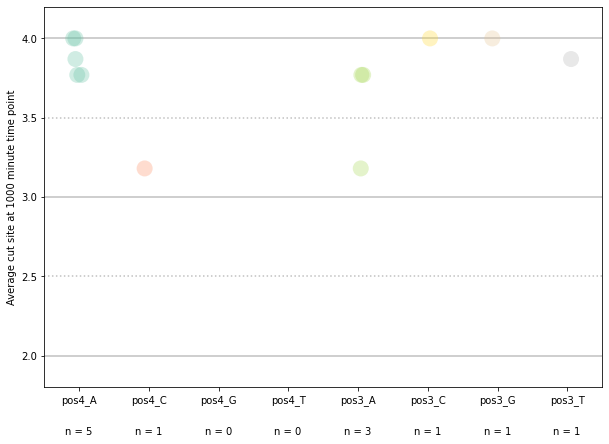

In [32]:
mean_swarm(small_ins_df, 'L_1000m')

In [33]:
small_ins_df.loc[:, ['sequence', 'L_1000m']]

,sequence,L_1000m
2094,TTTAGTGATAAGTGGAATGCCAATGTGG,3.77
5534,TTTAGTGATAAGTGGAATGCCCATGTGG,3.18
2825,TTTAGTGATAAGTGGAATGCCGATGTGG,NaN
3008,TTTAGTGATAAGTGGAATGCCTATGTGG,NaN
2094,TTTAGTGATAAGTGGAATGCCAATGTGG,3.77
204,TTTAGTGATAAGTGGAATGCCACTGTGG,4.0
4232,TTTAGTGATAAGTGGAATGCCAGTGTGG,4.0
1522,TTTAGTGATAAGTGGAATGCCATTGTGG,3.87


In [34]:
sequence

'GTGATAAGTGGAATGCCATG'

# Visualization of change in Cut site location based on time 

In [35]:
def cut_kinetics(
    df, 
    column_start_name = 'sequence', 
    column_end_name = 'L_3000m', 
    ylim = [2.7, 4.2], 
    figsize = [10, 5]):

    # Will draw the kinetics of a nuclease 
    
    
    titles = []
    row_end = len(df)
    for x in range(-7, -5):
        for base in 'ACGT':
            new_title = f'Insertion at position {abs(x)-3}{base}'
            titles.append(new_title)

    cut_df = df.loc[:, column_start_name:column_end_name]
    trans_df = cut_df.transpose()

    for x in range(0, len(cut_df)):
        column = trans_df.columns[x]  # get the column name instead of its contents
        data = trans_df[column].iloc[1:].dropna()  # drop NaN values in the column
        plt.figure(figsize = figsize)
        plt.plot(data)
        plt.scatter(x = trans_df.iloc[1:, x].index, y = trans_df.iloc[1:, x])
        plt.title(titles[x], size = 17)
        plt.ylabel('Average cut site', size = 15)
        plt.xlabel('Time point', size = 15)
        plt.ylim(ylim)
        plt.axhline(2, color='grey', alpha = 0.5)
        plt.axhline(2.5, color='grey', alpha = 0.5, linestyle=':')
        plt.axhline(3, color='grey', alpha = 0.5)
        plt.axhline(3.5, color='grey', alpha = 0.5, linestyle=':')
        plt.axhline(4, color='grey', alpha = 0.5)

C:\Users\justa\AppData\Local\Temp\ipykernel_24344\1689142584.py:26: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.scatter(x = trans_df.iloc[1:, x].index, y = trans_df.iloc[1:, x])
C:\Users\justa\AppData\Local\Temp\ipykernel_24344\1689142584.py:26: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.scatter(x = trans_df.iloc[1:, x].index, y = trans_df.iloc[1:, x])


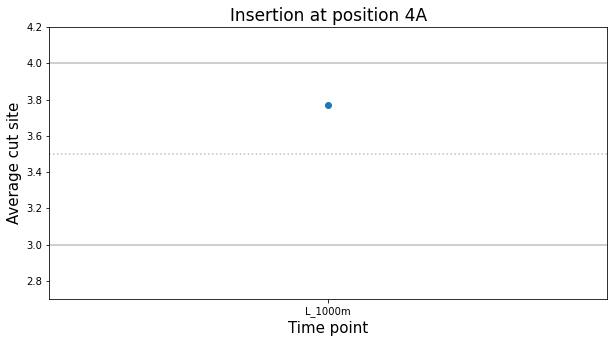

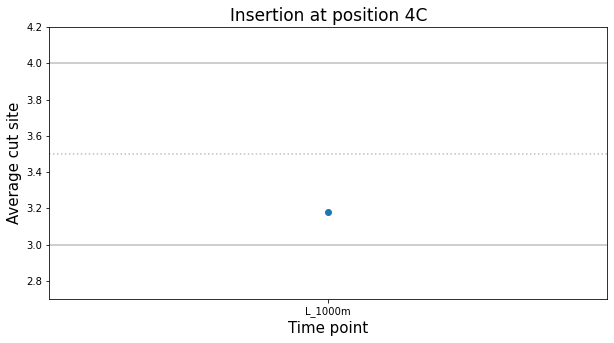

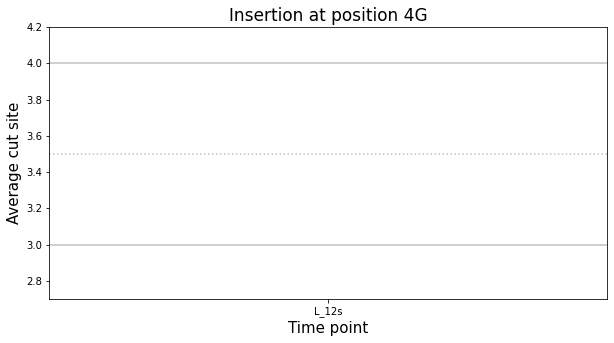

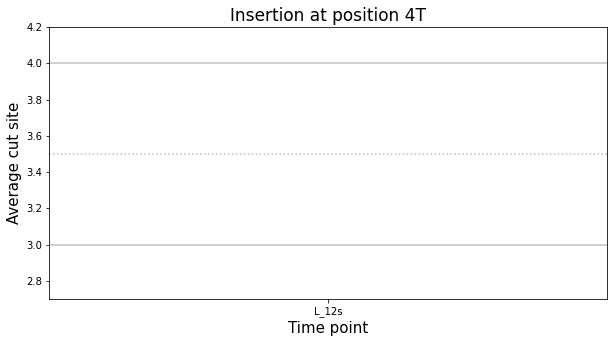

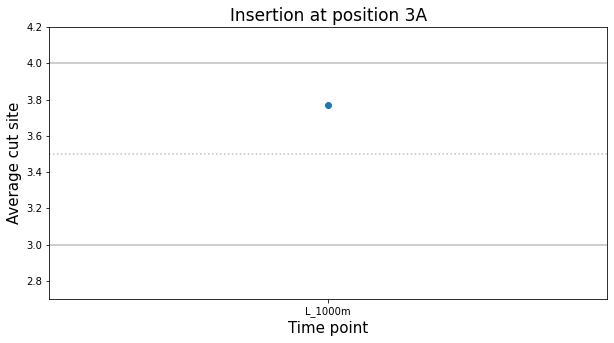

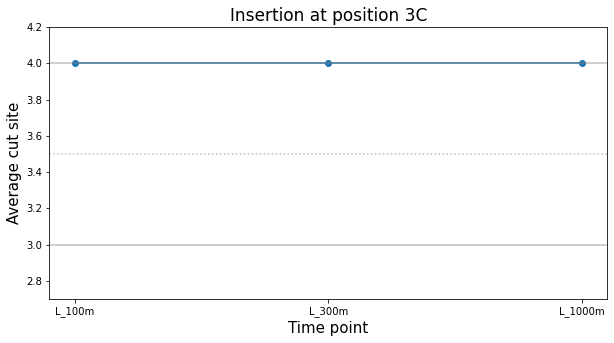

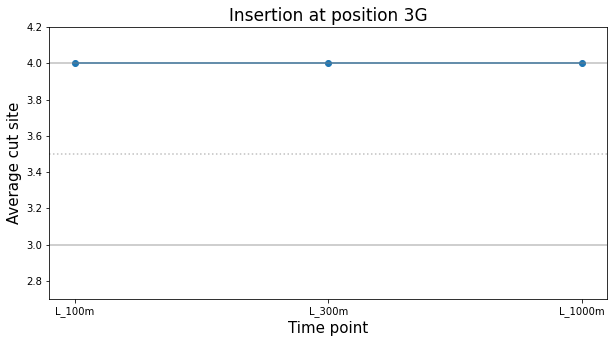

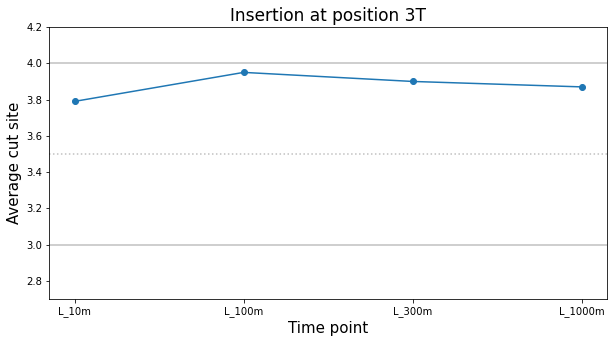

In [36]:
cut_kinetics(small_ins_df)

# Visualization of cut rate changes based on where a duplicated sequence is placed

In [37]:
cleavage[cleavage['sequence'].str.contains(f'^TTTA{sequence}TGG$')]

,sequence,descriptor,cleavage_rate_log,cleavage_rate_log_unc,L_12s,L_3m,L_10m,L_100m,L_300m,L_1000m,L_3000m,R_12s,R_3m,R_10m,R_100m,R_300m,R_1000m,R_3000m
1842,TTTAGTGATAAGTGGAATGCCATGTGG,pamTGG,-0.850572,0.043855,3.0,3.0,3.0,3.0,3.0,3.0,NaN,3.98,3.97,3.93,3.88,3.83,3.64,NaN


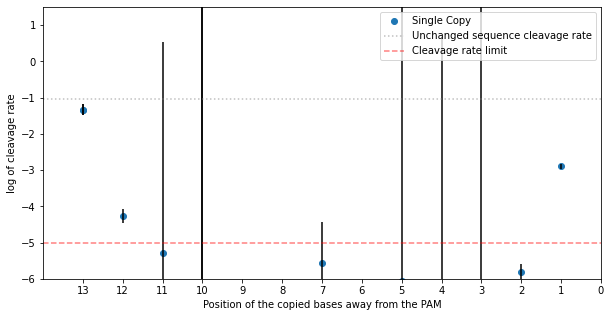

In [38]:
def cut_rate(df, x_axis='sequence', y_axis='cleavage_rate_log', y_error='cleavage_rate_log_unc', save = '', name = 'single cleavage rate'):
    
    #Creates the cleavage rate graph for a single data set 
    
    df = df.reset_index(drop=True)
    
    plt.figure(figsize=[10, 5])
    plt.scatter(x=df.loc[:, x_axis], y=df.loc[:, y_axis], label = 'Single Copy')#, color = 'blue')
    plt.errorbar(x=df.loc[:, x_axis], y=df.loc[:, y_axis], yerr=df.loc[:, y_error], fmt='none', color = 'black')
    
    plt.axhline(-1.032424, color='grey', alpha = 0.5, linestyle = ':', label = 'Unchanged sequence cleavage rate')
    plt.axhline(-5, color='red', alpha = 0.5, linestyle = '--', label = 'Cleavage rate limit')
    
    tick_labels = ['{}'.format(len(df)-2-x) for x in range(0, len(df))]
    plt.xticks(range(0, len(df)), tick_labels)
    
    plt.ylabel('log of cleavage rate')
    plt.xlabel('Position of the copied bases away from the PAM')
    #plt.title('Cleavage rate dependency on duplicated base insertions')
    
    plt.xlim(-1, len(df)-2)
    plt.ylim(-6, 1.5)
    plt.legend()
    
    if save == 'yes':
        plt.savefig(f"PNG {name}.png")
        plt.savefig(f'SVG {name}.svg', format='svg', bbox_inches='tight')

cut_rate(rep2_df)

,df_sequence,df_cleavage_rate_log,df_cleavage_rate_log_unc,df1_sequence,df1_cleavage_rate_log,df1_cleavage_rate_log_unc
0,TTTAGGTGATAAGTGGAATGCCATGTGG,-0.837469,0.051092,TTTAGGGTGATAAGTGGAATGCCATGTGG,-0.766509,0.059982
1,TTTAGTTGATAAGTGGAATGCCATGTGG,-0.894426,0.086489,TTTAGTTTGATAAGTGGAATGCCATGTGG,-0.847647,0.057511
2,TTTAGTGGATAAGTGGAATGCCATGTGG,-0.951566,0.250814,TTTAGTGGGATAAGTGGAATGCCATGTGG,-0.954529,0.158843
3,TTTAGTGAATAAGTGGAATGCCATGTGG,-1.772626,0.063104,TTTAGTGAAATAAGTGGAATGCCATGTGG,-1.808059,0.136626
4,TTTAGTGATTAAGTGGAATGCCATGTGG,-1.958337,0.078803,TTTAGTGATTTAAGTGGAATGCCATGTGG,-3.67275,0.13752
5,TTTAGTGATAAAGTGGAATGCCATGTGG,-2.034673,0.110895,TTTAGTGATAAAAGTGGAATGCCATGTGG,-4.259644,0.194458
6,TTTAGTGATAAAGTGGAATGCCATGTGG,-2.034673,0.110895,TTTAGTGATAAAAGTGGAATGCCATGTGG,-4.259644,0.194458
7,TTTAGTGATAAGGTGGAATGCCATGTGG,-3.261425,0.08083,TTTAGTGATAAGGGTGGAATGCCATGTGG,-22.696389,71.275135
8,TTTAGTGATAAGTTGGAATGCCATGTGG,-2.04225,0.079859,TTTAGTGATAAGTTTGGAATGCCATGTGG,-19.318642,7.767566
9,TTTAGTGATAAGTGGGAATGCCATGTGG,-3.396107,0.07359,TTTAGTGATAAGTGGGGAATGCCATGTGG,-24.78107,3.218324


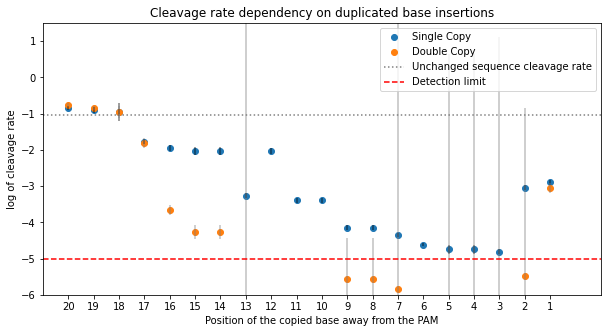

In [39]:
def cut_rate2(df, 
              df1, 
              legend1='Single Copy', 
              legend2='Double Copy', 
              legend3 = 'Unchanged sequence cleavage rate', 
              legend4 = 'Detection limit',
              save = '',
              name = 'sgRNA1'
):
    
    #Takes two dataframes and compares the cleavage rates between them also displaying the uncertainty
    
    df = df.reset_index(drop=True)
    df1 = df1.reset_index(drop=True)
    j_df = df.add_prefix('df_')
    j_df1 = df1.add_prefix('df1_')
    joint_df = pd.concat([j_df, j_df1], axis=1)
    
    x_data = df.index
    
    plt.figure(figsize=[10, 5])
    plt.scatter(x=x_data, y=joint_df.loc[:, 'df_cleavage_rate_log'], label=legend1)
    plt.scatter(x=x_data, y=joint_df.loc[:, 'df1_cleavage_rate_log'], label=legend2)
    
    # Add uncertainty bars
    plt.errorbar(x=x_data, y=joint_df.loc[:, 'df_cleavage_rate_log'], 
                 yerr=joint_df.loc[:, 'df_cleavage_rate_log_unc'], 
                 linestyle='None', color='black', alpha=0.5)
    plt.errorbar(x=x_data, y=joint_df.loc[:, 'df1_cleavage_rate_log'], 
                 yerr=joint_df.loc[:, 'df1_cleavage_rate_log_unc'], 
                 linestyle='None', color='grey', alpha=0.5)
    
    tick_labels = ['{}'.format(len(df)-x) for x in range(0, len(df))]
    plt.xticks(range(0, len(joint_df)), tick_labels)
    plt.ylabel('log of cleavage rate')
    plt.xlabel('Position of the copied base away from the PAM')
    plt.title('Cleavage rate dependency on duplicated base insertions')
    
    plt.axhline(-1.032424, color='grey', alpha=1, linestyle=':', label = legend3)
    plt.axhline(-5, color='red', alpha=1, linestyle='--', label = legend4)
    
    plt.xlim(-1, len(joint_df)+1)
    plt.ylim(-6, 1.5)
    plt.legend(loc='best')    
    
    if save == 'yes':
        plt.savefig(f"PNG {name} 2 dataframes.png")
        plt.savefig(f'SVG {name} 2 dataframes.svg', format='svg', bbox_inches='tight')
    
    return joint_df

cut_rate2(doubles_df, triples_df)

,df_sequence,df_cleavage_rate_log,df_cleavage_rate_log_unc,df1_sequence,df1_cleavage_rate_log,df1_cleavage_rate_log_unc
0,TTTAGGTGATAAGTGGAATGCCATGTGG,-0.837469,0.051092,TTTAGGGTGATAAGTGGAATGCCATGTGG,-0.766509,0.059982
1,TTTAGTTGATAAGTGGAATGCCATGTGG,-0.894426,0.086489,TTTAGTTTGATAAGTGGAATGCCATGTGG,-0.847647,0.057511
2,TTTAGTGGATAAGTGGAATGCCATGTGG,-0.951566,0.250814,TTTAGTGGGATAAGTGGAATGCCATGTGG,-0.954529,0.158843
3,TTTAGTGAATAAGTGGAATGCCATGTGG,-1.772626,0.063104,TTTAGTGAAATAAGTGGAATGCCATGTGG,-1.808059,0.136626
4,TTTAGTGATTAAGTGGAATGCCATGTGG,-1.958337,0.078803,TTTAGTGATTTAAGTGGAATGCCATGTGG,-3.67275,0.13752
5,TTTAGTGATAAAGTGGAATGCCATGTGG,-2.034673,0.110895,TTTAGTGATAAAAGTGGAATGCCATGTGG,-4.259644,0.194458
6,TTTAGTGATAAAGTGGAATGCCATGTGG,-2.034673,0.110895,TTTAGTGATAAAAGTGGAATGCCATGTGG,-4.259644,0.194458
7,TTTAGTGATAAGGTGGAATGCCATGTGG,-3.261425,0.08083,TTTAGTGATAAGGGTGGAATGCCATGTGG,-22.696389,71.275135
8,TTTAGTGATAAGTTGGAATGCCATGTGG,-2.04225,0.079859,TTTAGTGATAAGTTTGGAATGCCATGTGG,-19.318642,7.767566
9,TTTAGTGATAAGTGGGAATGCCATGTGG,-3.396107,0.07359,TTTAGTGATAAGTGGGGAATGCCATGTGG,-24.78107,3.218324


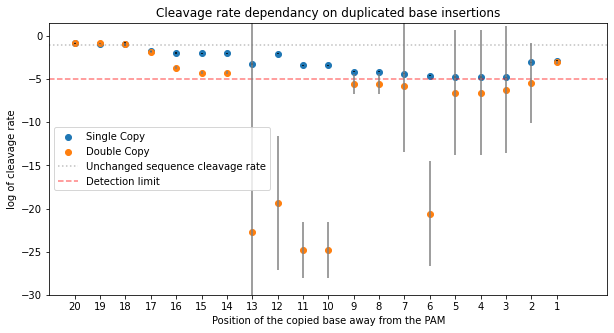

In [40]:
def cut_rate2(
    df, 
    df1, 
    legend1 = 'Single Copy', 
    legend2 = 'Double Copy', 
    legend3 = 'Unchanged sequence cleavage rate', 
    legend4 = 'Detection limit',
    save = '',
    name = 'sgRNA2'
):
    
    df = df.reset_index(drop=True)
    df1 = df1.reset_index(drop=True)
    j_df = df.add_prefix('df_')
    j_df1 = df1.add_prefix('df1_')
    joint_df = pd.concat([j_df, j_df1], axis = 1)
    
    x_data = df.index
    
    plt.figure(figsize = [10, 5])
    plt.scatter(x = x_data, y = joint_df.loc[:, 'df_cleavage_rate_log'], label = legend1)
    plt.scatter(x = x_data, y = joint_df.loc[:, 'df1_cleavage_rate_log'], label = legend2)
    
    plt.axhline(-1.032424, color='grey', alpha = 0.5, linestyle = ':', label = legend3)
    plt.axhline(-5, color='red', alpha = 0.5, linestyle = '--', label = legend4)
    
    plt.errorbar(x=x_data, y=joint_df.loc[:, 'df_cleavage_rate_log'], 
                 yerr=joint_df.loc[:, 'df_cleavage_rate_log_unc'], 
                 linestyle='None', color='black')
    plt.errorbar(x=x_data, y=joint_df.loc[:, 'df1_cleavage_rate_log'], 
                 yerr=joint_df.loc[:, 'df1_cleavage_rate_log_unc'], 
                 linestyle='None', color='grey')
    
    tick_labels = ['{}'.format(len(df)-x) for x in range(0, len(df))]
    plt.xticks(range(0, len(joint_df)), tick_labels)
    plt.ylabel('log of cleavage rate')
    plt.xlabel('Position of the copied base away from the PAM')
    plt.title('Cleavage rate dependancy on duplicated base insertions')
    #plt.text(x = 20, y = -6.9, s = '[PAM]')
    plt.xlim(-1, len(joint_df)+1)
    plt.ylim(-30, 1.5)
    plt.legend(loc='center left');
    
    if save == 'yes':
        plt.savefig(f"PNG {name} 2 dataframes.png")
        plt.savefig(f'SVG {name} 2 dataframes.svg', format='svg', bbox_inches='tight')
    
    return joint_df

cut_rate2(doubles_df, triples_df, save = 'yes')

# Visualization of single copy cleavage rates compared to a single insertion

In [41]:
def cut_rate_table(df, 
                  df1, 
                  df2, 
                  df3, 
                  df4
):    
    df = df.reset_index(drop=True)
    df1 = df1.reset_index(drop=True)
    df2 = df2.reset_index(drop=True)
    df3 = df3.reset_index(drop=True)
    df4 = df4.reset_index(drop=True)
    j_df = df.add_prefix('df_')
    j_df1 = df1.add_prefix('df1_')
    j_df2 = df2.add_prefix('df2_')
    j_df3 = df3.add_prefix('df3_')
    j_df4 = df4.add_prefix('df4_')
    joint_df = pd.concat([j_df, j_df1, j_df2, j_df3, j_df4], axis=1)
    
    return joint_df

cut_rate_table(doubles_df, A_df, C_df, G_df, T_df)

,df_sequence,df_cleavage_rate_log,df_cleavage_rate_log_unc,df1_sequence,df1_cleavage_rate_log,df1_cleavage_rate_log_unc,df2_sequence,df2_cleavage_rate_log,df2_cleavage_rate_log_unc,df3_sequence,df3_cleavage_rate_log,df3_cleavage_rate_log_unc,df4_sequence,df4_cleavage_rate_log,df4_cleavage_rate_log_unc
0,TTTAGGTGATAAGTGGAATGCCATGTGG,-0.837469,0.051092,TTTAAGTGATAAGTGGAATGCCATGTGG,-0.937034,0.085566,TTTACGTGATAAGTGGAATGCCATGTGG,-0.802586,0.16602,TTTAGGTGATAAGTGGAATGCCATGTGG,-0.837469,0.051092,TTTATGTGATAAGTGGAATGCCATGTGG,-0.980696,0.05737
1,TTTAGTTGATAAGTGGAATGCCATGTGG,-0.894426,0.086489,TTTAGATGATAAGTGGAATGCCATGTGG,-0.780902,0.07973,TTTAGCTGATAAGTGGAATGCCATGTGG,-0.709278,0.057814,TTTAGGTGATAAGTGGAATGCCATGTGG,-0.837469,0.051092,TTTAGTTGATAAGTGGAATGCCATGTGG,-0.894426,0.086489
2,TTTAGTGGATAAGTGGAATGCCATGTGG,-0.951566,0.250814,TTTAGTAGATAAGTGGAATGCCATGTGG,-1.040264,0.173964,TTTAGTCGATAAGTGGAATGCCATGTGG,-0.912954,0.047322,TTTAGTGGATAAGTGGAATGCCATGTGG,-0.951566,0.250814,TTTAGTTGATAAGTGGAATGCCATGTGG,-0.894426,0.086489
3,TTTAGTGAATAAGTGGAATGCCATGTGG,-1.772626,0.063104,TTTAGTGAATAAGTGGAATGCCATGTGG,-1.772626,0.063104,TTTAGTGCATAAGTGGAATGCCATGTGG,-2.485073,0.078522,TTTAGTGGATAAGTGGAATGCCATGTGG,-0.951566,0.250814,TTTAGTGTATAAGTGGAATGCCATGTGG,-1.035243,0.091283
4,TTTAGTGATTAAGTGGAATGCCATGTGG,-1.958337,0.078803,TTTAGTGAATAAGTGGAATGCCATGTGG,-1.772626,0.063104,TTTAGTGACTAAGTGGAATGCCATGTGG,-3.322679,0.087422,TTTAGTGAGTAAGTGGAATGCCATGTGG,-2.865425,0.097472,TTTAGTGATTAAGTGGAATGCCATGTGG,-1.958337,0.078803
5,TTTAGTGATAAAGTGGAATGCCATGTGG,-2.034673,0.110895,TTTAGTGATAAAGTGGAATGCCATGTGG,-2.034673,0.110895,TTTAGTGATCAAGTGGAATGCCATGTGG,-2.284034,0.085636,TTTAGTGATGAAGTGGAATGCCATGTGG,-2.075387,0.075908,TTTAGTGATTAAGTGGAATGCCATGTGG,-1.958337,0.078803
6,TTTAGTGATAAAGTGGAATGCCATGTGG,-2.034673,0.110895,TTTAGTGATAAAGTGGAATGCCATGTGG,-2.034673,0.110895,TTTAGTGATACAGTGGAATGCCATGTGG,-2.36841,0.082951,TTTAGTGATAGAGTGGAATGCCATGTGG,-2.494993,0.05259,TTTAGTGATATAGTGGAATGCCATGTGG,-2.307048,0.043452
7,TTTAGTGATAAGGTGGAATGCCATGTGG,-3.261425,0.08083,TTTAGTGATAAAGTGGAATGCCATGTGG,-2.034673,0.110895,TTTAGTGATAACGTGGAATGCCATGTGG,-3.265882,0.080283,TTTAGTGATAAGGTGGAATGCCATGTGG,-3.261425,0.08083,TTTAGTGATAATGTGGAATGCCATGTGG,-4.225869,0.092074
8,TTTAGTGATAAGTTGGAATGCCATGTGG,-2.04225,0.079859,TTTAGTGATAAGATGGAATGCCATGTGG,-4.055165,0.088453,TTTAGTGATAAGCTGGAATGCCATGTGG,-4.017372,0.117229,TTTAGTGATAAGGTGGAATGCCATGTGG,-3.261425,0.08083,TTTAGTGATAAGTTGGAATGCCATGTGG,-2.04225,0.079859
9,TTTAGTGATAAGTGGGAATGCCATGTGG,-3.396107,0.07359,TTTAGTGATAAGTAGGAATGCCATGTGG,-2.334041,0.114384,TTTAGTGATAAGTCGGAATGCCATGTGG,-3.252673,0.156124,TTTAGTGATAAGTGGGAATGCCATGTGG,-3.396107,0.07359,TTTAGTGATAAGTTGGAATGCCATGTGG,-2.04225,0.079859


ValueError: The number of FixedLocator locations (21), usually from a call to set_ticks, does not match the number of ticklabels (20).

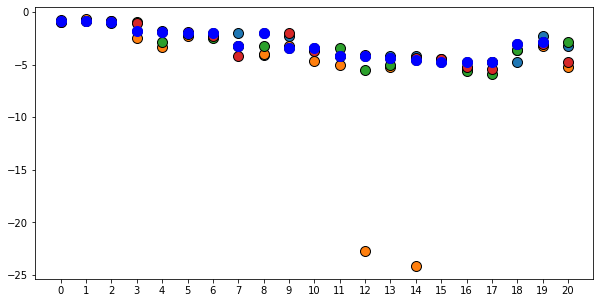

In [42]:
def cut_rate_comp(df, 
                  df1, 
                  df2, 
                  df3, 
                  df4, 
                  legend1='Single Copy', 
                  legend2 = 'Inserted A', 
                  legend3 = 'Inserted C', 
                  legend4 = 'Inserted G', 
                  legend5 = 'Inserted T', 
                  legend6 = 'Unchanged sequence cleavage rate', 
                  legend7 = 'Detection limit',
                  save = '',
                  name = 'sgRNA1'
):
    
    #Takes multiple dataframes and compares the cleavage rates between them
    
    joint_df = cut_rate_table(df, df1, df2, df3, df4)
    
    x_data = joint_df.index
    
    plt.figure(figsize=[10, 5])
    #plt.scatter(x=x_data, y=joint_df.loc[:19, 'df_cleavage_rate_log'], color = 'blue', label=legend1)
    plt.scatter(x=x_data, y=joint_df.loc[:, 'df1_cleavage_rate_log'], s = 100, edgecolor='black', label=legend2)
    plt.scatter(x=x_data, y=joint_df.loc[:, 'df2_cleavage_rate_log'], s = 100, edgecolor='black', label=legend3)
    plt.scatter(x=x_data, y=joint_df.loc[:, 'df3_cleavage_rate_log'], s = 100, edgecolor='black', label=legend4)
    plt.scatter(x=x_data, y=joint_df.loc[:, 'df4_cleavage_rate_log'], s = 100, edgecolor='black', label=legend5)
    plt.scatter(x=x_data, y=joint_df.loc[:, 'df_cleavage_rate_log'], s = 100, color = 'blue', label=legend1)
    
    tick_labels = ['{}'.format(len(df)-x) for x in range(0, len(df))]
    plt.xticks(range(0, len(joint_df)), tick_labels)
    plt.ylabel('log of cleavage rate')
    plt.xlabel('Position of the inserted base away from the PAM')
    #plt.title('Cleavage rate comparison between sequences with different insertions and sequences with a single duplicated base')
    
    plt.axhline(-1.032424, color='grey', alpha=1, linestyle=':', label = legend6)
    plt.axhline(-5, color='red', alpha=1, linestyle='--', label = legend7)
    
    plt.xlim(-2, len(joint_df))
    plt.ylim(-7, 4)
    plt.legend(loc='upper right')    
    
    if save == 'yes':
        plt.savefig(f"PNG {name} 2 dataframes.png")
        plt.savefig(f'SVG {name} 2 dataframes.svg', format='svg', bbox_inches='tight')

cut_rate_comp(doubles_df, A_df, C_df, G_df, T_df)

# Statistics

In [43]:
#collect all the data I need
table = cut_rate_table(rep2_df, AN_df, CN_df, GN_df, TN_df)

#remove the doubles_df
table_wide = table.loc[:, ['df1_cleavage_rate_log', 'df2_cleavage_rate_log', 'df3_cleavage_rate_log', 'df4_cleavage_rate_log']] 

#only doubles_df
dup_data = pd.DataFrame(table.loc[:, 'df_cleavage_rate_log']) 

#turn both wide dataframes into long formats
long = table_wide.melt(value_name='value').reset_index(drop = True)
long_dup = dup_data.melt(value_name='value').reset_index(drop = True)

#Mark what values need to be removed
values_to_exclude = long_dup['value'].unique()

# Filter out the rows from the bigger dataframe that match the values in the smaller dataframe
filtered_df = long[~long['value'].isin(values_to_exclude)].reset_index(drop = True)

#Concat the two dataframes
concated_df = pd.concat([filtered_df, long_dup], ignore_index=True).dropna()

# Create separate data arrays for each category
categories = concated_df['variable'].unique()
data_arrays = [concated_df[concated_df['variable'] == cat]['value'].values for cat in categories]

# Perform Welch ANOVA
f_statistic, p_value = stats.f_oneway(*data_arrays)

# Print the results
print("F-statistic:", f_statistic)
print("p-value:", p_value)

F-statistic: 0.9657825236755754
p-value: 0.42881390774135286


In [46]:
#Doubles and Triples dfs comparison

double_df = doubles_df.reset_index(drop=True)
triple_df= triples_df.reset_index(drop=True)
j_df = double_df.add_prefix('df_')
j_df1 = triple_df.add_prefix('df1_')
table_wide = pd.concat([j_df, j_df1], axis = 1)
table_wide = table_wide.loc[:, ['df_cleavage_rate_log', 'df1_cleavage_rate_log']]
table_long = table_wide.melt(value_name='value').dropna()

# Create separate data arrays for each category
categories = table_long['variable'].unique()
data_arrays = [table_long[table_long['variable'] == cat]['value'].values for cat in categories]

# Perform Welch ANOVA
f_statistic, p_value = stats.f_oneway(*data_arrays)

# Print the results
print("F-statistic:", f_statistic)
print("p-value:", p_value)

F-statistic: 8.838797462071541
p-value: 0.005096903713606487
